# 1. Dự báo timeseries với model LSTM 
## 1.1. Giới thiệu chung

Trong [bài 1](https://github.com/phamdinhkhanh/LSTM/blob/master/LSTM.ipynb) chúng ta đã biết cách thức để thiết lập một mạng `LSTM`, chuẩn hóa dữ liệu đầu vào và fitting model để dự báo số liệu chuỗi thời gian. Tuy nhiên chuỗi dữ liệu `Shampoo` sử dụng ở bài trước có một đặc điểm đó là xu hướng trend rõ ràng nhưng yếu tố mùa vụ không rõ ràng. Do đó qui luật trong quá khứ sẽ khó có thể lặp lại ở tương lai như chuỗi có yếu tố mùa vụ và một điều hiển nhiên là những chuỗi càng không có yếu tố mùa vụ thì việc dự báo càng trở nên khó chuẩn xác hơn. Chính vì vậy trong ví dụ này ta sẽ hồi qui mô hình đối với một chuỗi số mà đặc tính mùa vụ thể hiện một cách rõ ràng và kiểm tra xem liệu rằng `LSTM` có nắm bắt được đúng qui luật mùa vụ của chuỗi để đưa ra dự báo chuẩn xác hay không.

## 1.2. Chuỗi dữ liệu

Chuỗi dự liệu được sử dụng trong bài viết là `International Airline Passangers` đo lường lượng khách hàng sử dụng dịch vụ hàng không (đơn vị 1000 người) theo từng tháng trong khoảng thời gian từ tháng 1 năm 1949 đến tháng 12 năm 1960. Chuỗi dữ liệu bao gồm 144 quan sát và kéo dài trong vòng 12 năm.

Dữ liệu có thể được download tại [DataMarket - International airline passengers](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) hoặc cũng có thể lấy trong ngay bài viết này ở cùng folder với tên file là `international-airline-passengers.csv`. Chúng ta sẽ đọc và kiểm tra dữ liệu.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

series = pd.read_csv('international-airline-passengers.csv', sep = ',', header = 0, index_col = 0, names = ['Month', 'No_Pass'])
series.head()

,No_Pass
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


Trường `No_Pass` chính là lượng khách hàng trong tháng và là đại lượng cần được dự báo. Đồng thời dữ liệu trễ của nó được sử dụng làm biến dự báo. Ở đây chúng ta tạm thời chưa đánh giá thêm các đại lượng kinh tế vi mô, vĩ mô có ảnh hưởng tới nhu cầu sử dụng dịch vụ hàng không bởi hạn chế của dữ liệu là chỉ giới hạn trong doanh số khách hàng và việc mở rộng thêm biến sẽ khiến vấn đề trở nên phức tạp, đòi hỏi nhiều các phân tích khác về hàng hóa thay thế, mối quan hệ kinh tế giữa các ngành, bối cảnh kinh tế, xã hội và các yếu tố khác. Kiểm tra tính phân phối của dữ liệu.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CB8F69F240>]],
      dtype=object)

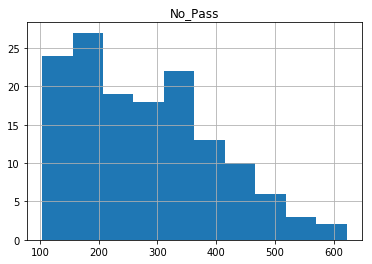

In [2]:
series.hist(bins = 10)

In [3]:
series.describe()

,No_Pass
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Ta có thể rút ra một số nhận xét về phân phối về doanh số khách hàng như sau:

* Doanh số khách hàng nằm trong khoảng từ 100-600 (nghìn người).
* Đồ thị phân phối xác xuất lệch trái và giá trị của phân phối xác xuất giảm dần theo độ lớn của `No_Pass`. Điều này thể hiện ở giá trị mean > median.
* Phương sai của biến tương đối lớn và bằng 2/5 so với mean. Phương sai lớn là do ảnh hưởng của việc trend tăng và do biến động mùa vụ.

Để làm rõ nhận định về chuỗi có yếu tố mùa vụ và trend tăng chúng ta sẽ phân tích biểu đồ chuỗi `No_Pass`.

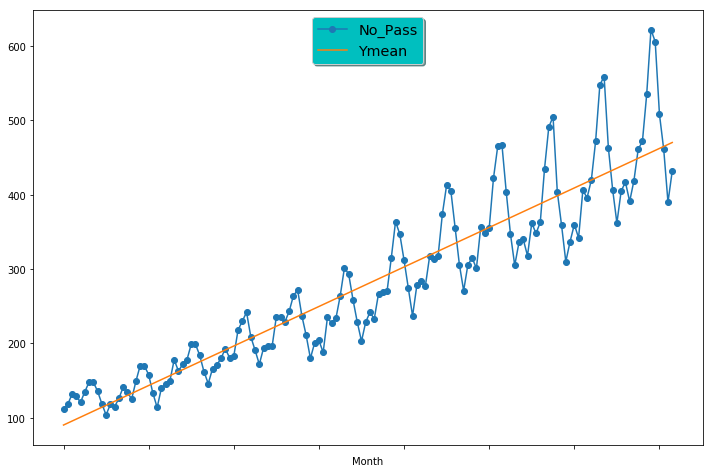

In [5]:
from sklearn import linear_model
import numpy as np
l_reg = linear_model.LinearRegression(fit_intercept = True)
t = np.arange(len(series)).reshape(-1, 1)
l_reg.fit(t, series)
Ymean = l_reg.predict(t)
series.plot(figsize = (12, 8), style = 'o-', label = 'Y')
plt.plot(Ymean, label = 'Ymean')
legend = plt.legend(loc = 'upper center', shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('C')

Ta có thể thấy rằng chuỗi có xu hướng tăng theo thời gian và có yếu tố mùa vụ với chu kì bằng 12 tháng. Một chu kì bắt đầu từ tháng 1 và kết thúc vào tháng 12 của năm. Yếu tố chu kì này sẽ giúp chuỗi dễ dự báo hơn do qui luật trong quá khứ được lặp lại rõ ràng trong tương lai. 

# 2. Xây dựng mạng neuron LSTM

## 2.1. Các bước dự báo 

Tương tự như [bài trước](https://github.com/phamdinhkhanh/LSTM/blob/master/LSTM.ipynb). Về cơ bản khi xây dựng model LSTM chúng ta sẽ trải qua các bước cơ bản như sau:

1. Chuẩn bị dữ liệu: Chuẩn hóa dữ liệu đầu vào và chia mẫu train/test.
2. Xây dựng mạng neuron `LSTM`.
3. Lựa chọn hàm loss function và thuật toán gradient descent sử dụng để tìm nghiệm tối ưu.
4. Đánh giá lại mức độ sai số dự báo.
5. Áp dụng model để dự báo cho các khoảng thời gian tiếp theo.

Kết quả model sẽ thay đổi dựa vào số lượng các biến trễ mà ta sử dụng để hồi qui mô hình. Thông thường các biến được sử dụng để dự báo sẽ có độ trễ từ 1 đến 3. Chúng ta không nên lựa chọn độ trễ dài hơn bởi sẽ làm tăng số lượng biến đưa vào mô hình hồi qui và dễ dàng xảy ra hiện tượng overfiting. Hơn nữa việc tăng số lượng biến làm tăng khối lượng tính toán và làm tăng chi phí thời gian. Bên dưới chúng ta sẽ xây dựng model LSTM cho 3 độ trễ là 1 tháng, 2 tháng, 3 tháng và đánh giá sai số dự báo của cả 3 mô hình.

## 2.2. Xây dựng mạng LSTM với biến trễ 1 tháng

Chúng ta coi chuỗi dữ liệu hiện tại ứng với thời điểm t là biến được dự báo và giá trị trễ của nó là (t-1) là biến dự báo. Các biến này sẽ được `Scale` trong khoảng (0,1) để thuật toán `gradient descent` hội tụ nhanh hơn và không bị nhảy khỏi các điểm global optimal points.

Tạo hàm `create_shift_series` khởi tạo data frame chứa chuỗi hiện tại và trễ của nó.

In [6]:
def create_shift_series(series, look_back):
    data_shift = series
    cols = ['X']
    for i in range(look_back):
        data_shift = pd.merge(data_shift, series.shift(i+1), how = 'left', left_index = True, right_index = True)
        cols.append('X%s'%(i+1))
    data_shift.columns = cols
    data_shift.fillna(0, inplace = True)
    return data_shift.iloc[look_back:, :]

In [7]:
data_shift = create_shift_series(series = series, look_back = 1)
data_shift.head()

,X,X1
Month,,
1949-02,118,112.0
1949-03,132,118.0
1949-04,129,132.0
1949-05,121,129.0
1949-06,135,121.0


`Scale` dữ liệu theo phương pháp `MinMaxScaler` để các giá trị của biến dự báo và được dự báo nằm trong khoảng (0, 1) và chia mẫu train/test.

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_shift)
#split into train and test sets
train_size = int(len(data_shift)*2/3)
test_size = len(data_shift) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print('Train shape: %s ; Test shape: %s'%(train.shape, test.shape))
print('Train 5 first rows: \n %s,\nTest 5 first rows: \n %s '%(train[:5], test[:5]))

Train shape: (95, 2) ; Test shape: (48, 2)
Train 5 first rows: 
 [[0.02702703 0.01544402]
 [0.05405405 0.02702703]
 [0.04826255 0.05405405]
 [0.03281853 0.04826255]
 [0.05984556 0.03281853]],
Test 5 first rows: 
 [[0.40733591 0.38996139]
 [0.38030888 0.40733591]
 [0.48648649 0.38030888]
 [0.47104247 0.48648649]
 [0.48455598 0.47104247]] 


In [9]:
trainX, trainY = train[:, 1], train[:, 0]
testX, testY = test[:, 1], test[:, 0]

Chúng ta cần reshape lại dữ liệu theo kích thước 3D với các chiều lần lượt là `[samples, time_steps, features]` trong đó:
* samples: Số lượng các quan sát được sử dụng làm input dự báo.
* time_steps: Bước nhảy thời gian giữa 2 quan sát liên tiếp của biến được dự báo.
* features: Số lượng các biến dự báo được sử dụng trong model.
Các ma trận sẽ được reshape lại như sau:

In [10]:
# reshape input to be [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], 1, 1)
testX = testX.reshape(testX.shape[0], 1, 1)

Xây dựng mạng neuron `LSTM`. Mô hình mạng neuron này cũng giống như [Bài 1](https://github.com/phamdinhkhanh/LSTM/blob/master/LSTM.ipynb), bao gồm 1 layer LSTM với 4 units được kết nối trực tiếp với một fully connected layer với 1 unit duy nhất chính là đầu ra của kết quả dự báo. Thuật toán được sử dụng để cập nhật nghiệm là `Adam` và hàm loss function được lựa chọn là `mean_squared_error`.

In [11]:
# Create LSTM model
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
import numpy as np

look_back = 1
model = Sequential()
model.add(LSTM(4, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 100, batch_size = 1, verbose = 0, shuffle = False)

Using TensorFlow backend.


Dự báo kết quả trên tập train và trên tập test từ mạng neuron vừa xây dựng. Kết quả thu được cần được chuyển hóa ngược từ hàm `scale` ban đầu để ra được giá trị dự báo cho chuỗi thời gian do đầu vào của chúng ta đã được scale.

In [12]:
# Make prediction
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# Invert prediction
trainPredictInv = scaler.inverse_transform(np.concatenate((trainPredict, trainX.reshape(trainX.shape[0], -1)), axis = 1))[:, 0]
trainYInv = data_shift.iloc[:train_size, 0].values
testPredictInv = scaler.inverse_transform(np.concatenate((testPredict, testX.reshape(testX.shape[0], -1)), axis = 1))[:, 0]
testYInv = data_shift.iloc[train_size:, 0].values

In [13]:
# Root mean squared error
mse_train = math.sqrt(mean_squared_error(trainYInv[:-1], trainPredictInv[1:]))
mse_test = math.sqrt(mean_squared_error(testYInv[:-1], testPredictInv[1:]))
print('Train MSE: %s' %mse_train)
print('Test MSE: %s' %mse_test)

Train MSE: 8.85471388407624
Test MSE: 16.44112060030951


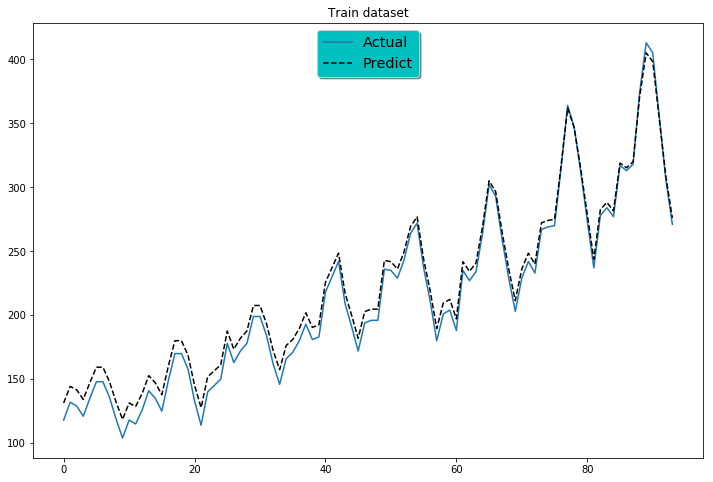

In [14]:
plt.figure(figsize = (12, 8))
plt.plot(trainYInv[:-1], label = 'Actual')
plt.plot(trainPredictInv[1:], 'k--', label = 'Predict')
plt.title('Train dataset')
legend = plt.legend(loc = 'upper center', shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('C')

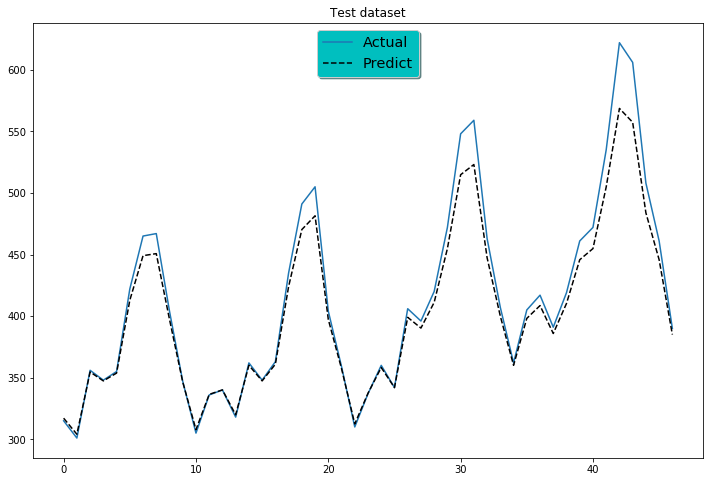

In [15]:
plt.figure(figsize = (12, 8))
plt.plot(testYInv[:-1], label = 'Actual')
plt.plot(testPredictInv[1:], 'k--', label = 'Predict')
plt.title('Test dataset')
legend = plt.legend(loc = 'upper center', shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('C')

## 2.2. Xây dựng mạng LSTM với biến trễ 2 tháng

Sử dụng hàm `create_shift_series` để tạo data frame chứa biến dự báo là trễ 2 tháng, trễ 1 tháng và biến được dự báo là giá trị hiện tại.

In [16]:
data_shift = create_shift_series(series = series, look_back = 2)
data_shift.head()

,X,X1,X2
Month,,,
1949-03,132,118.0,112.0
1949-04,129,132.0,118.0
1949-05,121,129.0,132.0
1949-06,135,121.0,129.0
1949-07,148,135.0,121.0


In [17]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_shift)
#split into train and test sets
train_size = int(len(data_shift)*2/3)
test_size = len(data_shift) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print('Train shape: %s ; Test shape: %s'%(train.shape, test.shape))
print('Train 5 first rows: \n %s,\nTest 5 first rows: \n %s '%(train[:5], test[:5]))

Train shape: (94, 3) ; Test shape: (48, 3)
Train 5 first rows: 
 [[0.05405405 0.02702703 0.01544402]
 [0.04826255 0.05405405 0.02702703]
 [0.03281853 0.04826255 0.05405405]
 [0.05984556 0.03281853 0.04826255]
 [0.08494208 0.05984556 0.03281853]],
Test 5 first rows: 
 [[0.40733591 0.38996139 0.32239382]
 [0.38030888 0.40733591 0.38996139]
 [0.48648649 0.38030888 0.40733591]
 [0.47104247 0.48648649 0.38030888]
 [0.48455598 0.47104247 0.48648649]] 


In [18]:
trainX, trainY = train[:, 1:], train[:, 0]
testX, testY = test[:, 1:], test[:, 0]

In [19]:
# reshape input to be [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

In [20]:
print('trainX shape: %s'% str(trainX.shape))
print('testX shape: %s'% str(testX.shape))

trainX shape: (94, 1, 2)
testX shape: (48, 1, 2)


In [21]:
# create and fit the LSTM network
look_back = 2
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [22]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [23]:
# Invert prediction
trainPredictInv = scaler.inverse_transform(np.concatenate((trainPredict, trainX.reshape(trainX.shape[0], trainX.shape[2])), axis = 1))[:, 0]
testPredictInv = scaler.inverse_transform(np.concatenate((testPredict, testX.reshape(testX.shape[0], testX.shape[2])), axis = 1))[:, 0]
# Actual values
trainYInv = np.array(data_shift.iloc[:train_size, 0])
testYInv = np.array(data_shift.iloc[train_size:, 0])

In [24]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYInv[:-1], trainPredictInv[1:]))
print('Train Score: %.2f RMSE ' %trainScore)
testScore = math.sqrt(mean_squared_error(testYInv[:-1], testPredictInv[1:]))
print('Test Score: %.2f RMSE ' %testScore)

Train Score: 5.22 RMSE 
Test Score: 23.50 RMSE 


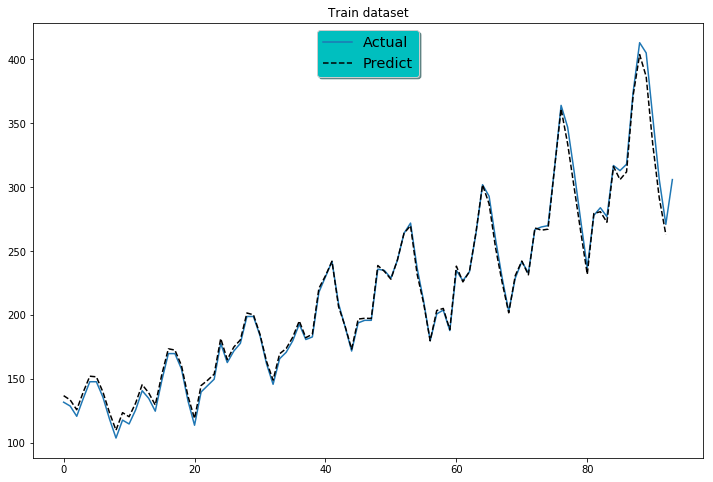

In [25]:
plt.figure(figsize =(12, 8) )
plt.plot(trainYInv, label = 'Actual')
plt.plot(trainPredictInv[1:], 'k--', label = 'Predict')
plt.title('Train dataset')
legend = plt.legend(loc = 'upper center', shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('C')

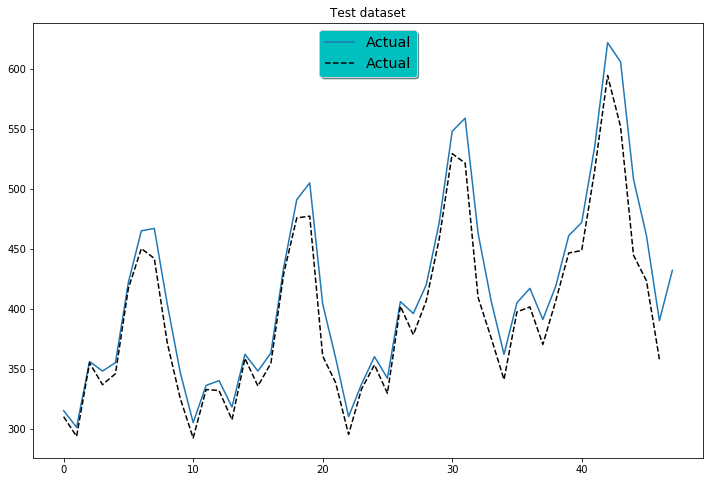

In [26]:
plt.figure(figsize =(12, 8) )
plt.plot(testYInv, label = 'Actual')
plt.plot(testPredictInv[1:], 'k--', label = 'Actual')
plt.title('Test dataset')
legend = plt.legend(loc = 'upper center', shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('C')

## 2.3. Xây dựng code tổng quát

Bên dưới chúng ta sẽ xây dựng một class tổng quát là `LSTM_network` có các thuộc tính và phương thức hỗ trợ để xây dựng một mạng neuron `LSTM` dựa trên việc khai báo chuỗi dữ liệu đầu vào, hàm scaler, tỷ lệ chia mẫu split_rate, độ trễ và các tham số của quá trình fitting như batch_size, epochs. Việc compile mô hình dưới dạng một class giúp ta dễ dàng kế thừa và tái sử dụng lại code trong những mô hình triển khai sau này. Đồng thời quá trình xử lý sẽ được tự động hóa dựa trên các phương thức đã được tổng hợp vào class `LSTM`.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as ml
import matplotlib.colors as mc
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

class LSTM_network(object):
    """docstring for LSMT_network"""
    def __init__(self, series, scaler, data_shift = None, trainX = None, trainY = None, testX = None, testY = None, model = None, 
                 split_rate = 2/3, look_back = 1, n_neurons = 4, epochs = 100, batch_size = 1, verbose = 0):
        self.series = series
        self.data_shift = data_shift
        self.trainX = trainX
        self.trainY = trainY
        self.testX = testX
        self.testY = testY
        self.split_rate = split_rate
        self.scaler = scaler
        self.model = model
        self.look_back = look_back
        self.n_neurons = n_neurons
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
    
    def create_shift_series(self):
        self.data_shift = self.series
        cols = ['X']
        for i in range(self.look_back):
            self.data_shift = pd.merge(self.data_shift, self.series.shift(i+1), how = 'left', left_index = True, right_index = True)
            cols.append('X%s'%(i+1))
        self.data_shift.columns = cols
        self.data_shift.fillna(0, inplace = True)
        self.data_shift = self.data_shift.iloc[self.look_back:, :]
        return self.data_shift

    def train_test_split(self):
        dataset = self.scaler.fit_transform(self.data_shift)
        train_size = int(len(self.data_shift)*self.split_rate)
        train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
        self.trainX, self.trainY = train[:, 1:], train[:, 0]
        self.testX, self.testY = test[:, 1:], test[:, 0]
        self.trainX = self.trainX.reshape(self.trainX.shape[0], 1, self.trainX.shape[1])
        self.testX = self.testX.reshape(self.testX.shape[0], 1, self.testX.shape[1])
        return self.scaler, self.trainX, self.trainY, self.testX, self.testY
        
    def initial_model(self):
        self.model = Sequential()
        self.model.add(LSTM(self.n_neurons, input_shape = (1, self.look_back)))
        self.model.add(Dense(1))
        self.model.compile(loss = 'mean_squared_error', optimizer = 'adam')
        self.model.fit(self.trainX, self.trainY, epochs = self.epochs, batch_size = self.batch_size, verbose = self.verbose)
        print("=============================================================================================\n")
        return self.model
    
    def predict_train_test(self):
        trainPredict = self.model.predict(self.trainX)
        testPredict = self.model.predict(self.testX)
        return trainPredict, testPredict
    
    def measure_error(self, trainPredict, testPredict):
        # Invert prediction
        trainPredictInv = self.scaler.inverse_transform(np.concatenate((trainPredict, self.trainX.reshape(self.trainX.shape[0], self.trainX.shape[2])), axis = 1))[:, 0]
        testPredictInv = self.scaler.inverse_transform(np.concatenate((testPredict, self.testX.reshape(self.testX.shape[0], self.testX.shape[2])), axis = 1))[:, 0]
        # Actual values
        trainYInv = np.array(data_shift.iloc[:self.trainX.shape[0], 0])
        testYInv = np.array(data_shift.iloc[self.trainX.shape[0]:, 0])
        # Calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(trainYInv[:-1], trainPredictInv[1:]))
        print('Train Score: %.2f RMSE \n' %trainScore)
        testScore = math.sqrt(mean_squared_error(testYInv[:-1], testPredictInv[1:]))
        print('Test Score: %.2f RMSE \n' %testScore)
        f, (ax1, ax2) = plt.subplots(2 , 1, figsize = (24, 16))
        ax1.plot(trainYInv, label = 'Actual')
        ax1.plot(trainPredictInv[1:], 'k--', label = 'Predict')
        ax1.set_ylabel('Train dataset', fontsize = 'x-large')
        ax2.plot(testYInv, label = 'Actual')
        ax2.plot(testPredictInv[1:], 'k--', label = 'Predict')
        ax2.set_ylabel('Test dataset', fontsize = 'x-large')
        legend = ax1.legend(loc='upper center', shadow=True, fontsize='x-large')
        legend.get_frame().set_facecolor('C')
        return trainPredictInv, trainYInv, testPredictInv, testYInv
    
    def predict_next(self, n_pred):
        print("=============================================================================================\n")
        for i in range(n_pred):
            forecastY = self.testY.reshape(-1, 1)
            Ypred = model.predict(forecastY[-self.look_back:].reshape(1,1,self.look_back))
            forecastY = np.concatenate((forecastY, Ypred), axis = 0)
        forecastY = forecastY[-(n_pred+self.look_back+1):]
        inversePredData = [forecastY[-(n_pred+i):] if i == 0 else forecastY[-(n_pred+i):-i] for i in range(self.look_back+1)]
        inversePredData = np.concatenate(inversePredData, axis = 1)
        Ypred = self.scaler.inverse_transform(inversePredData)[:, 0]
        print("Forecast value in next %d months: %s"%(Ypred.shape[0], Ypred))
        Ymerge = np.concatenate((testPredictInv, Ypred))
        Ygraph = np.concatenate((np.arange(Ymerge.shape[0]).reshape(Ymerge.shape[0], -1), Ymerge.reshape(Ymerge.shape[0], -1)), axis = 1)
        fig, ax = plt.subplots(figsize = (24, 8))
        line_segments = ml.LineCollection([Ygraph[:47], Ygraph[47:]], colors = ['b', 'r'], linestyle = ['solid', 'dashdot'], linewidth = 2)
        ax.add_collection(line_segments)
        ax.autoscale()
        ax.set_ylabel('Values')
        ax.set_xlabel('Months')
        plt.title('Predict in next %d months'%Ypred.shape[0], fontsize = 'x-large')
        return Ypred

Tiếp theo chúng ta sẽ sử dụng class `LSTM_network` vừa tạo để xây dựng mô hình dự báo với độ trễ của biến là 3 tháng (`look_back = 3`) như bên dưới.


Train Score: 7.87 RMSE 

Test Score: 34.79 RMSE 


Forecast value in next 12 months: [391.         419.         461.         472.         535.
 622.         606.         508.         461.         390.
 432.         412.23814213]


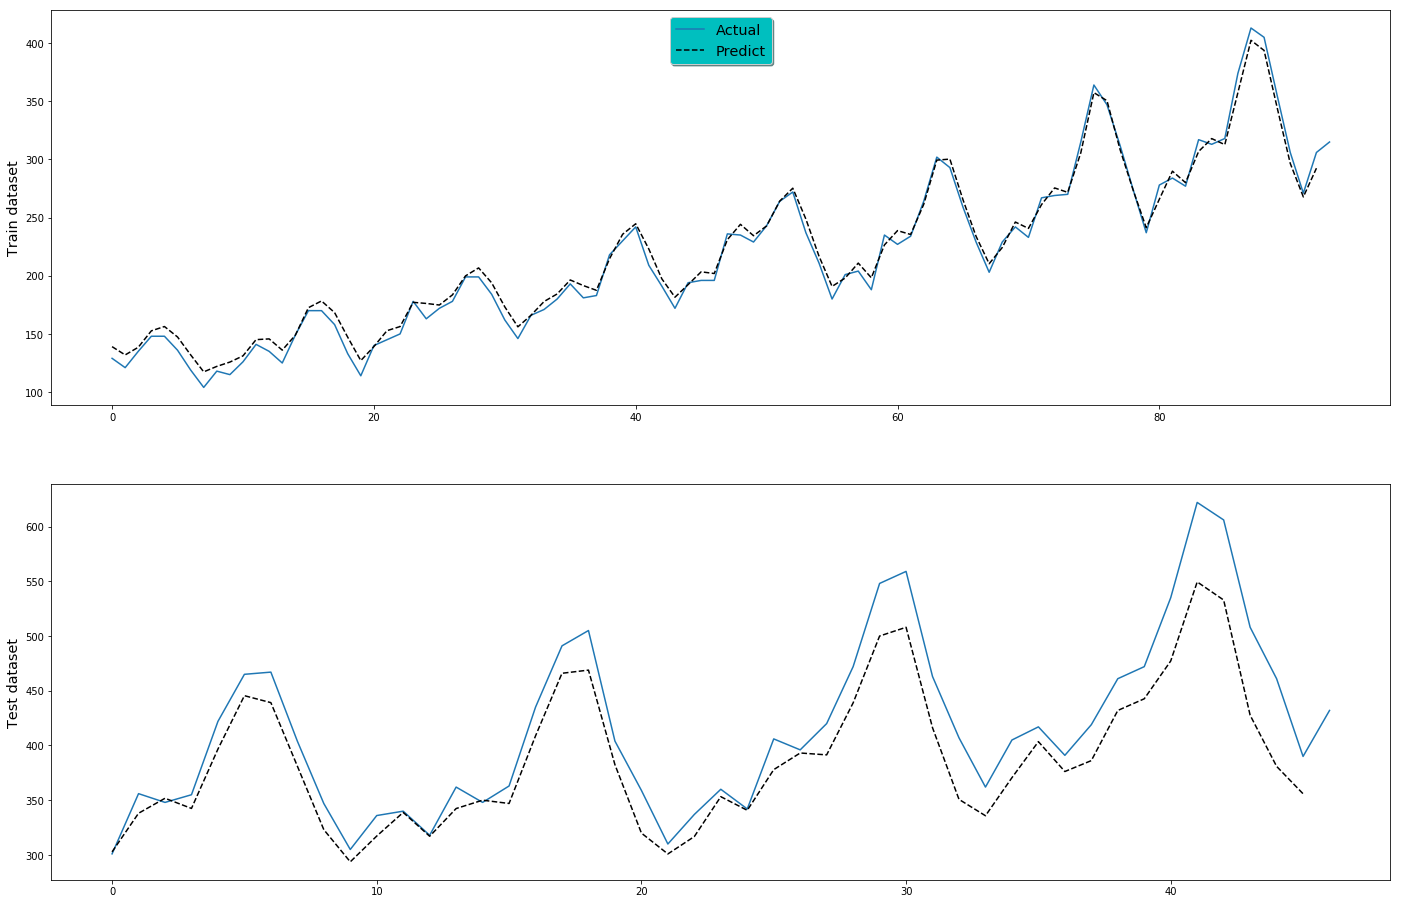

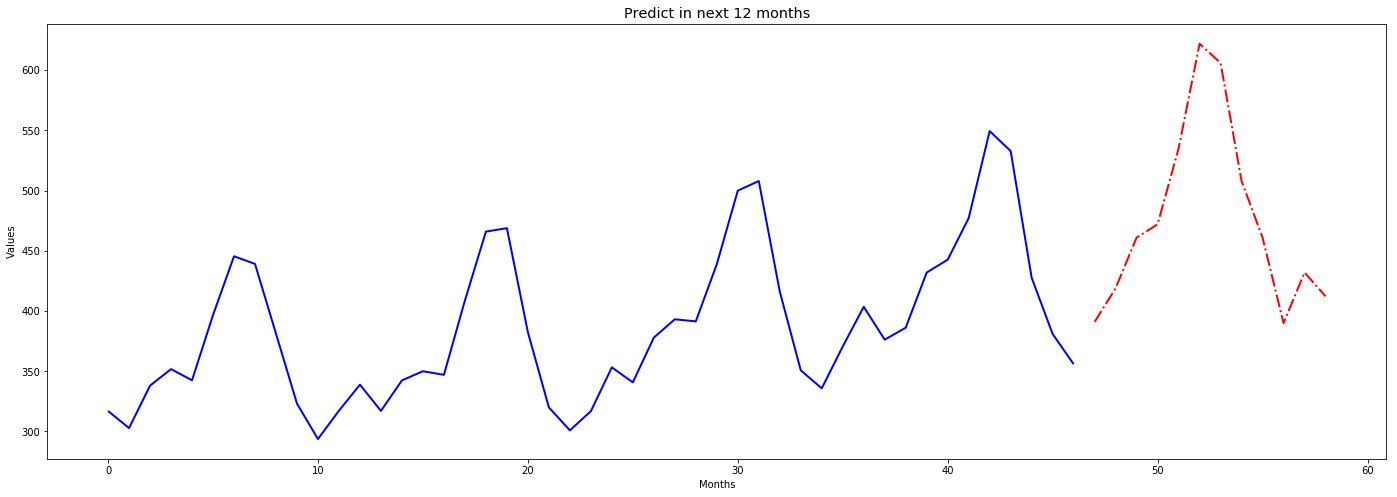

In [28]:
# Initialize LSTM object
LSTM_obj = LSTM_network(series = series, scaler = MinMaxScaler(feature_range = (0,1)), look_back = 3, split_rate = 2/3, verbose = 0)
# Create data shift frame
data_shift = LSTM_obj.create_shift_series()
# Train, test split
scaler, trainX, trainY, testX, testY = LSTM_obj.train_test_split()
# Initialize model 
model = LSTM_obj.initial_model()
# Predict train and test
trainPredict, testPredict = LSTM_obj.predict_train_test()
trainPredictInv, trainYInv, testPredictInv, testYInv = LSTM_obj.measure_error(trainPredict, testPredict)
# Predict on next 12 months
Ypred = LSTM_obj.predict_next(12)

Kết quả trên tập train cho thấy với mô hình độ trễ 3 tháng thì giá trị sai số thấp hơn so với các độ trễ 1 và 2 tháng. Kết quả trên tập test lại thể hiện trái ngược khi độ trễ 1 tháng có sai số nhỏ hơn so với 3 tháng. Điều này là do mô hình độ trễ 3 tháng có nhiều biến hơn và hiện tượng overfiting đã làm cho kết quả trên tập train dự báo tốt hơn nhưng tập test dự báo kém hơn.

## 2.4. Xây dựng class Model, Data và LSTM_network 

Chúng ta nhận thấy rằng class `LSTM_network` ở mục `2.3` là chưa tối ưu bởi các nhược điểm sau:
* Class có quá nhiều các phương thức và thuộc tính do đó sẽ làm cho kích thước của class lớn hơn gây tổn thất tài nguyên bộ nhớ và chi phí thời gian cần xử lý.
* Các phương thức và thuộc tính liên quan đến model và dữ liệu hoàn tách biệt nhau. Việc đặt chúng vào chung một class sẽ gây lẫn lộn và không đẹp về mặt cấu trúc.

Từ các nhận định đó, nếu chúng ta tạo 2 class khác nhau để quản lý các phần về Model và Data riêng rẽ sẽ làm cấu trúc class trở nên rõ ràng, mạch lạc hơn. Class chính vẫn là `LSTM_network` có nhiệm vụ kế thừa các phương thức và thuộc tính của 2 class con là `Model` và `Data`. Nhiệm vụ của các class sẽ như sau:
* Model: Chuyên quản lý các phần liên quan đến mô hình như xây dựng cấu trúc mạng, qui định hàm loss function và thuật toán gradient descent.
* Data: Biến đổi, xử lý và lưu trữ dữ liệu.
* LSTM_network: Điều khiển Model và Data nhằm mục đích đánh giá mô hình và dự báo.

Code của các class sẽ được thiết kế chi tiết như sau:

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as ml
import matplotlib.colors as mc
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


class Model(object):
    """create model for training and fitting"""
    def __init__(self, trainX, trainY, look_back, n_neurons = 4, epochs = 100, batch_size = 1, verbose = 0):
        self.model = Sequential()
        self.look_back = look_back
        self.model.add(LSTM(n_neurons, input_shape = (1, look_back)))
        self.model.add(Dense(1))
        self.model.compile(loss = 'mean_squared_error', optimizer = 'adam')
        self.model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size, verbose = verbose)

    
class Data(object):
    """prepare train/test data"""
    def __init__(self, series, scaler, look_back, split_rate = 2/3):
        self.series = series
        self.split_rate = split_rate
        self.look_back = look_back
        self.data_shift = self.create_shift_series()
        self.scaler, self.trainX, self.trainY, self.testX, self.testY = self.train_test_split(scaler)
        
    def create_shift_series(self):
        self.data_shift = self.series
        cols = ['X']
        for i in range(self.look_back):
            self.data_shift = pd.merge(self.data_shift, self.series.shift(i+1), how = 'left', left_index = True, right_index = True)
            cols.append('X%s'%(i+1))
        self.data_shift.columns = cols
        self.data_shift.fillna(0, inplace = True)
        self.data_shift = self.data_shift.iloc[self.look_back:, :]
        return self.data_shift
    
    def train_test_split(self, scaler):
        dataset = scaler.fit_transform(self.data_shift)
        train_size = int(len(self.data_shift)*self.split_rate)
        train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
        self.trainX, self.trainY = train[:, 1:], train[:, 0]
        self.testX, self.testY = test[:, 1:], test[:, 0]
        self.trainX = self.trainX.reshape(self.trainX.shape[0], 1, self.trainX.shape[1])
        self.testX = self.testX.reshape(self.testX.shape[0], 1, self.testX.shape[1])
        return scaler, self.trainX, self.trainY, self.testX, self.testY
    
    
class LSTM_network(object):
    """initialize LSTM_network include two attribute
       model: define the neuron network, loss function and algorithm gradient descent
       data: prepare series, train and test dataset and scaler function.
    """
    def __init__(self, model, data):
        self.model = model
        self.data = data
    
    def predict_train_test(self):
        trainPredict = self.model.model.predict(self.data.trainX)
        testPredict = self.model.model.predict(self.data.testX)
        return trainPredict, testPredict
    
    def measure_error(self, trainPredict, testPredict):
        # Invert prediction
        trainPredictInv = self.data.scaler.inverse_transform(np.concatenate((trainPredict, self.data.trainX.reshape(self.data.trainX.shape[0], self.data.trainX.shape[2])), axis = 1))[:, 0]
        testPredictInv = self.data.scaler.inverse_transform(np.concatenate((testPredict, self.data.testX.reshape(self.data.testX.shape[0], self.data.testX.shape[2])), axis = 1))[:, 0]
        # Actual values
        trainYInv = np.array(self.data.data_shift.iloc[:self.data.trainX.shape[0], 0])
        testYInv = np.array(self.data.data_shift.iloc[self.data.trainX.shape[0]:, 0])
        # Calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(trainYInv[:-1], trainPredictInv[1:]))
        print('Train Score: %.2f RMSE \n' %trainScore)
        testScore = math.sqrt(mean_squared_error(testYInv[:-1], testPredictInv[1:]))
        print('Test Score: %.2f RMSE \n' %testScore)
        f, (ax1, ax2) = plt.subplots(2 , 1, figsize = (24, 16))
        ax1.plot(trainYInv, label = 'Actual')
        ax1.plot(trainPredictInv[1:], 'k--', label = 'Predict')
        ax1.set_ylabel('Train dataset', fontsize = 'x-large')
        ax2.plot(testYInv, label = 'Actual')
        ax2.plot(testPredictInv[1:], 'k--', label = 'Predict')
        ax2.set_ylabel('Test dataset', fontsize = 'x-large')
        legend = ax1.legend(loc='upper center', shadow=True, fontsize='x-large')
        legend.get_frame().set_facecolor('C')
        return trainPredictInv, trainYInv, testPredictInv, testYInv
    
    def predict_next(self, n_pred, testPredictInv):
        print("=============================================================================================\n")
        for i in range(n_pred):
            forecastY = self.data.testY.reshape(-1, 1)
            Ypred = self.model.model.predict(forecastY[-self.model.look_back:].reshape(1,1,self.model.look_back))
            forecastY = np.concatenate((forecastY, Ypred), axis = 0)
        forecastY = forecastY[-(n_pred+self.model.look_back+1):]
        inversePredData = [forecastY[-(n_pred+i):] if i == 0 else forecastY[-(n_pred+i):-i] for i in range(self.model.look_back+1)]
        inversePredData = np.concatenate(inversePredData, axis = 1)
        Ypred = self.data.scaler.inverse_transform(inversePredData)[:, 0]
        print("Forecast value in next %d months: %s"%(Ypred.shape[0], Ypred))
        Ymerge = np.concatenate((testPredictInv, Ypred))
        Ygraph = np.concatenate((np.arange(Ymerge.shape[0]).reshape(Ymerge.shape[0], -1), Ymerge.reshape(Ymerge.shape[0], -1)), axis = 1)
        fig, ax = plt.subplots(figsize = (24, 8))
        line_segments = ml.LineCollection([Ygraph[:47], Ygraph[47:]], colors = ['b', 'r'], linestyle = ['solid', 'dashdot'], linewidth = 2)
        ax.add_collection(line_segments)
        ax.autoscale()
        ax.set_ylabel('Values')
        ax.set_xlabel('Months')
        plt.title('Predict in next %d months'%Ypred.shape[0], fontsize = 'x-large')
        return Ypred

In [18]:
# Step 1: Chuẩn bị dữ liệu
scaler = MinMaxScaler(feature_range = (0,1))
data = Data(series = series, scaler = scaler, look_back = 3, split_rate = 2/3)

In [27]:
# Step 2: Khởi tạo mạng LSMT
model = Model(data.trainX, data.trainY, data.look_back, n_neurons = 4, epochs = 100, batch_size = 1, verbose = 0)

Train Score: 5.56 RMSE 

Test Score: 27.17 RMSE 


Forecast value in next 12 months: [391.         419.         461.         472.         535.
 622.         606.         508.         461.         390.
 432.         445.40073776]


array([391.        , 419.        , 461.        , 472.        ,
       535.        , 622.        , 606.        , 508.        ,
       461.        , 390.        , 432.        , 445.40073776])

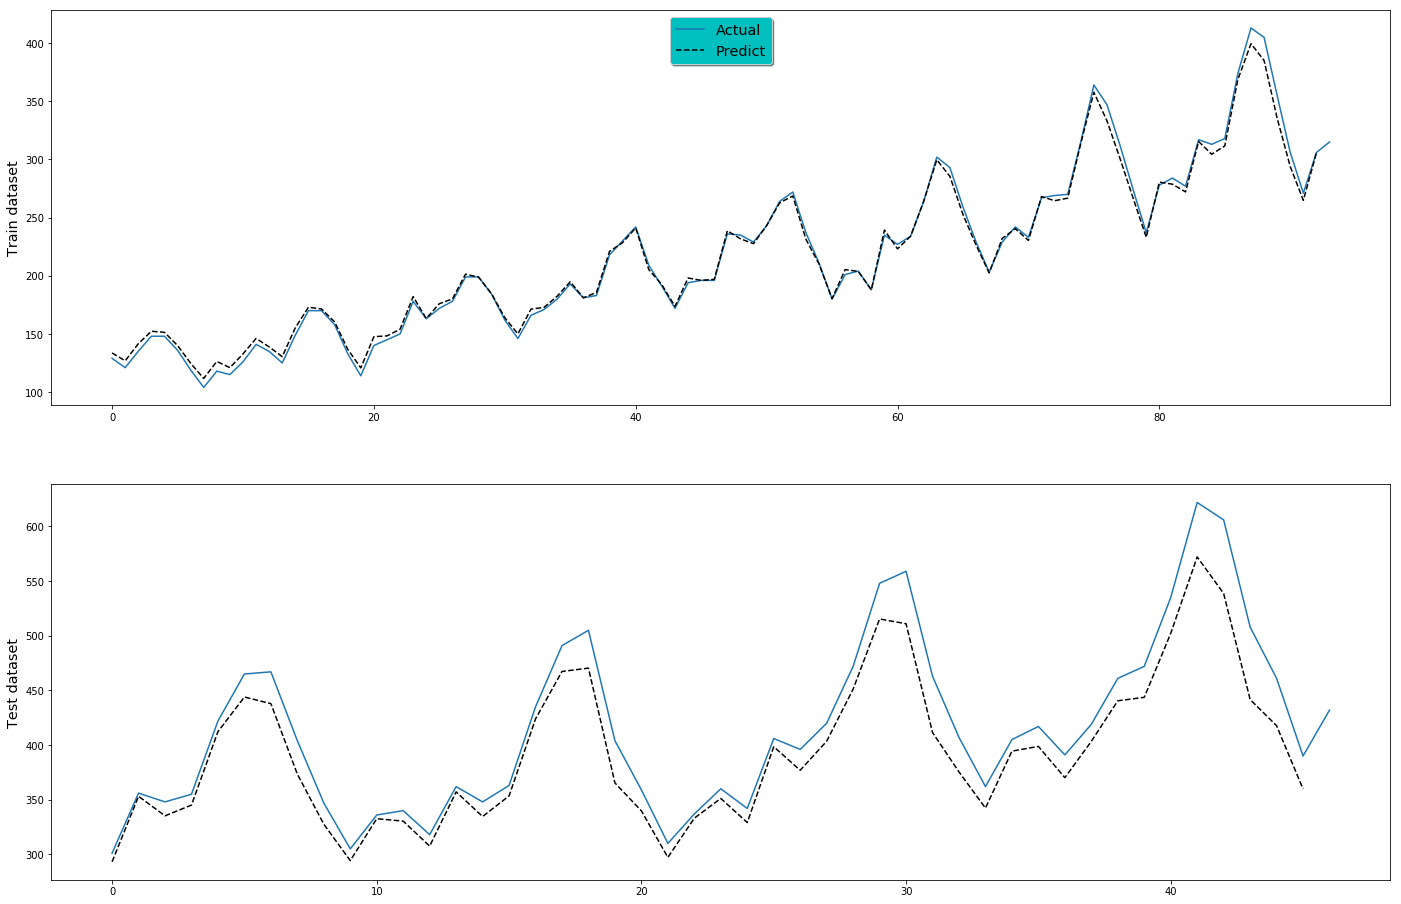

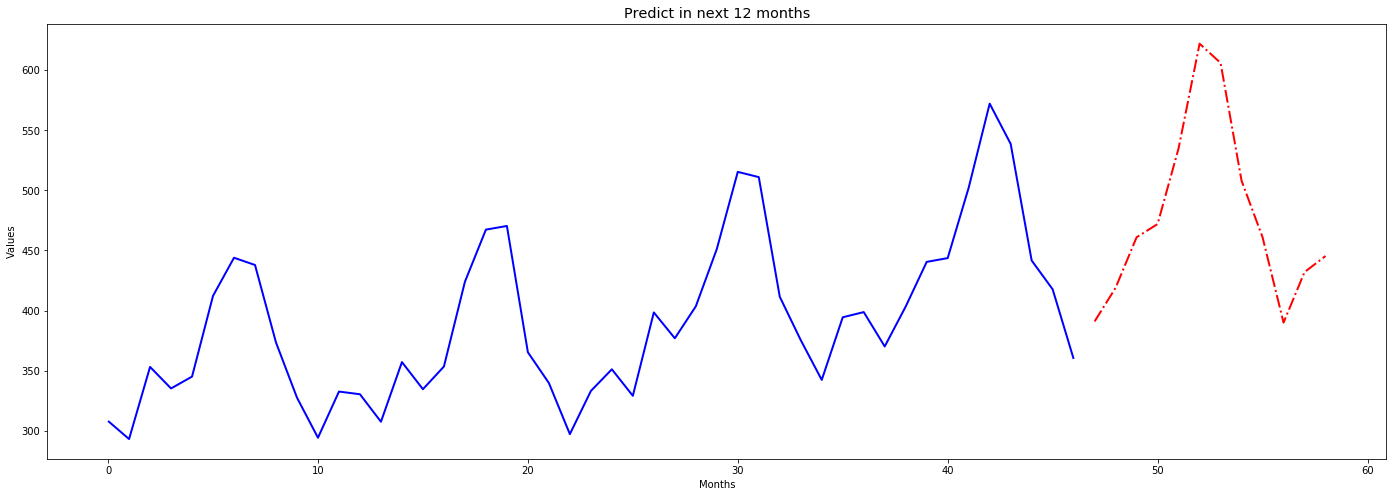

In [36]:
# Step 3: Đánh giá model
# 3.1 Khởi tạo class LSTM network
lstm_nw = LSTM_network(model = model, data = data)
# 3.2 Dự báo trên train và test
trainPredict, testPredict = lstm_nw.predict_train_test()
# 3.3 Đánh giá sai số trên tập train và test
trainPredictInv, trainYInv, testPredictInv, testYInv = lstm_nw.measure_error(trainPredict, testPredict)
# 3.4 Dự báo trong 12 phiên sắp tới
lstm_nw.predict_next(12, testPredictInv)

Sau khi tổ chức (`refactor`) lại các class chúng ta nhận thấy các step đã trở nên rõ ràng hơn. Mỗi một class đảm nhiệm một nhiệm vụ xử lý ứng với chức năng của nó mà không bị chồng lấn. Nội dung code cũng dễ hiểu và dễ hình dung hơn so với trước. Trong các bài toán trải qua nhiều bước xử lý, việc `refactor` code là một phần rất cần thiết để mang lại hiệu quả trong việc quản lý, kế thừa và đọc hiểu.


## 2.5. Tài liệu tham khảo

Tài liệu tham khảo:

1. [Sơ đồ model LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

2. [Blog machinelearningmastery của Jason Brownlee](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras)

3. [Tổng hợp các phương pháp dự báo timeseries](https://www.datascience.com/blog/time-series-forecasting-machine-learning-differences)

4. [Dự báo timeseries trafic kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting)

5. [LSTM dự báo timeseries blog towardsdatascience](https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f)

6. [Dự báo giá S&P500 sử dụng LSTM](https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks)